# ensemble

In [66]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import glob
import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [46]:
df = pd.read_csv("../input/shopee-product-matching/train_fold.csv")
df = df[df["fold"] == 0]
tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(tmp)
df["len_target"] = [len(x) for x in df["target"].values]


In [25]:
posting_id = df["posting_id"].values

In [26]:
def get_best_epochs(model_path, early_stopping_round=3):
    file_len = len(glob.glob(f"{model_path}/indices_epoch*.npy"))
    return file_len - early_stopping_round - 1 # epoch は0はじまりなのでさらに1ひく


model_dict = {
    "bert": "../output/exp044/20210420161425", # CV: 0.862
}

model_dist_dict = {}
    
for k, path in model_dict.items():
    best_epochs = get_best_epochs(path)
    
    model_dist_dict[k] = {
        "embeddings":  np.load(f"{path}/embeddings_epoch{best_epochs}.npy")
    }
    
    model_dist_dict[k]["cosine_similarity"] = get_cosine_similarity(model_dist_dict[k]["embeddings"]).astype(np.float16)

In [27]:
def get_cosine_similarity(embeddings):
    normed_emb = normalize(embeddings).astype(np.float16)
    distances = np.matmul(normed_emb, normed_emb.T).T
    
    return distances

In [28]:
def get_cv(df, similarity_matrix, threshold, indices=None, pred_name="pred", min_n=2, mode="min"):
    posting_id = df["posting_id"]
    preds = []
    for k in range(len(df)):
        if mode == "min": # euclid distance etc
            IDX = np.where(similarity_matrix[k, ] < threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[:min_n]
        if mode == "max": # cosine similarlity
            IDX = np.where(similarity_matrix[k, ] > threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[-min_n:]
            
        if indices is None:
            pred = posting_id[IDX]
        else:
            if len(IDX) < min_n:
                IDX = np.argsort(similarity_matrix[k, ])[:min_n]
            idx = indices[k, IDX]
            pred = posting_id[idx]
        preds.append(pred)
    
    df[pred_name] = preds
    f1score, precision, recall = calc_cv(df, col_name=pred_name)
    return f1score, precision, recall

In [47]:
def get_nearest_neighbor(df, similarity_matrix, n=5):
    posting_id = df["posting_id"].values
    target = df["target"].values
    preds = []
    for k in range(len(df)):
        IDX = np.argsort(similarity_matrix[k, ])[-n:][::-1]
        pred = {}

        for i in range(n):
            pred[f"{i}_posting_id"] = posting_id[IDX[i]]
            pred[f"{i}_distance"] = similarity_matrix[k, IDX[i]]
            pred[f"{i}_is_correct"] = posting_id[IDX[i]] in target[k]
        
        pred["len_target"] = len(target[k])
        preds.append(pred)
    
    return pd.DataFrame(preds)

In [84]:
df_ret = get_nearest_neighbor(df, 
                              similarity_matrix=model_dist_dict["bert"]["cosine_similarity"],
                              n=50)

In [92]:
def calc_fscore(df, nth):
    
    df_ret.groupby(f"{nth}_is_correct")[f"{nth}_distance"].hist(bins=100, alpha=0.3, range=(0, 1), legend=True, figsize=(20, 4))
    plt.title(f"{nth}th histogram")
    plt.show()
    
    thresholds = []
    fscores = []
    best_score = 0
    best_th = 0
    for th in np.arange(0, 1, 0.01):
        y_true = df[f"{nth}_is_correct"].values
        y_pred = df[f"{nth}_distance"].values > th
        
        fscore = f1_score(y_true, y_pred)
        thresholds.append(th)
        fscores.append(fscore)
        
        if best_score < fscore:
            best_score = fscore
            best_th = th
    
    plt.figure(figsize=(20, 4))
    plt.plot(thresholds, fscores)
    plt.vlines(best_th, ymin=0, ymax=1, color="red", linestyles="dashed")
    plt.title(f"{nth}th threshold search(MAX: {best_score}(th={best_th}))")
    plt.xlabel("threshold")
    plt.ylabel("fscore")
    plt.show()
    return best_th

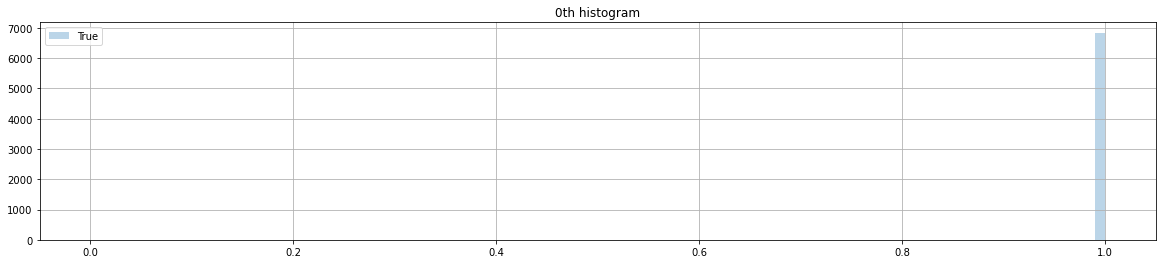

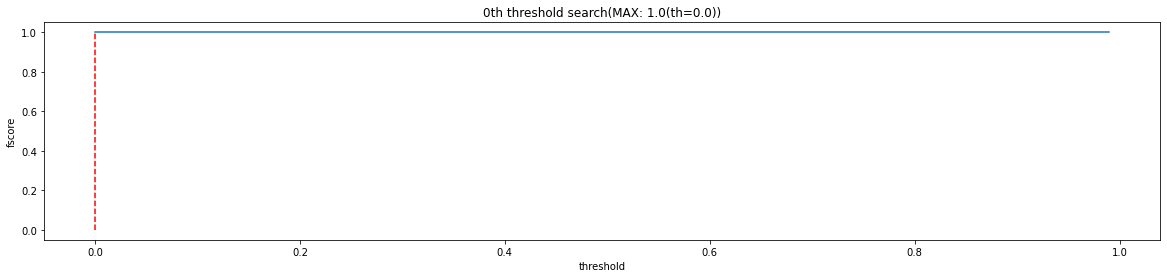

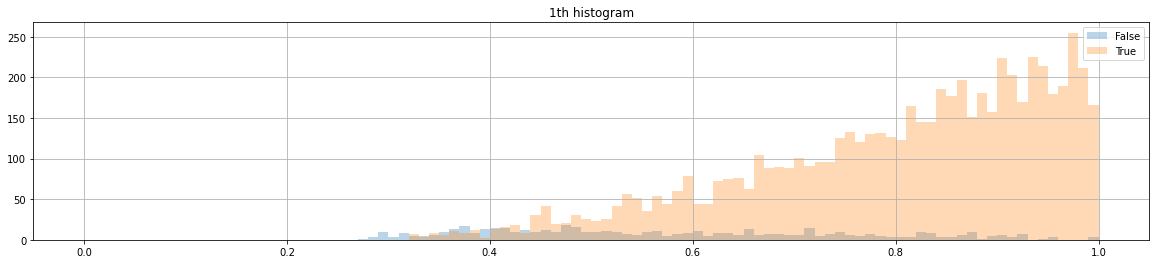

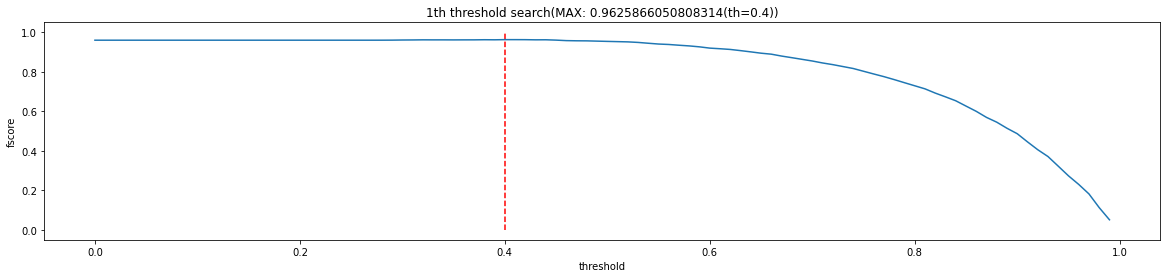

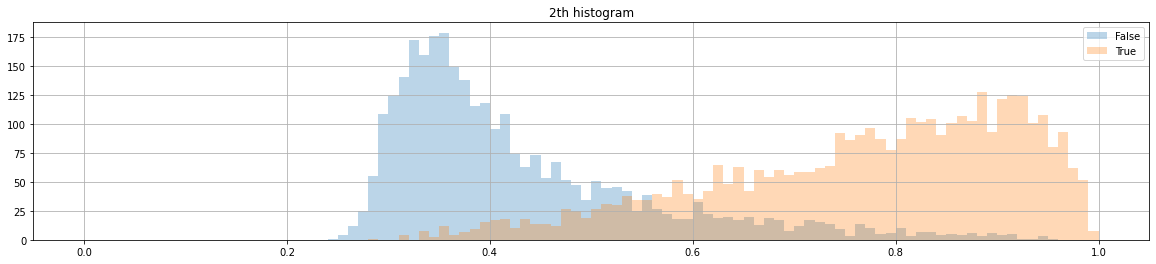

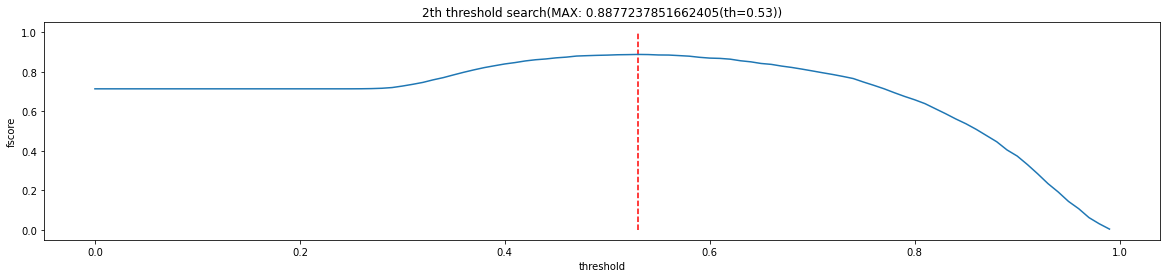

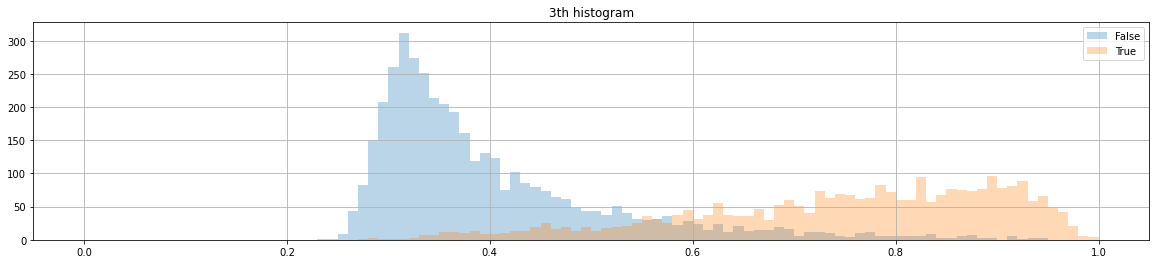

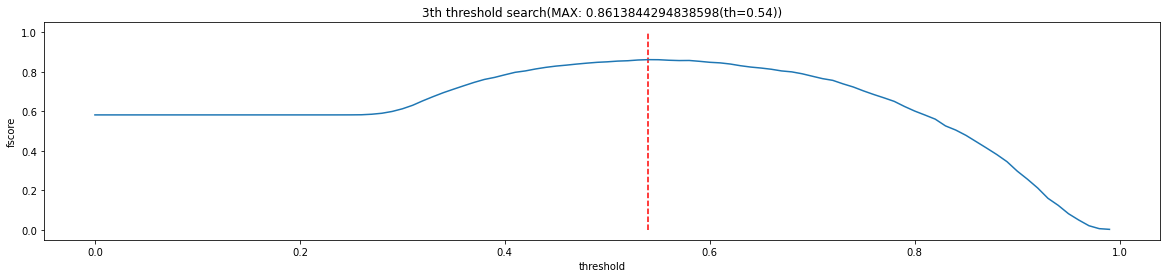

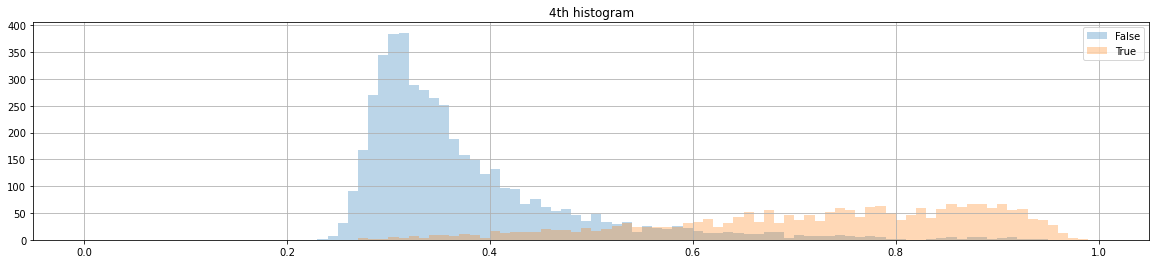

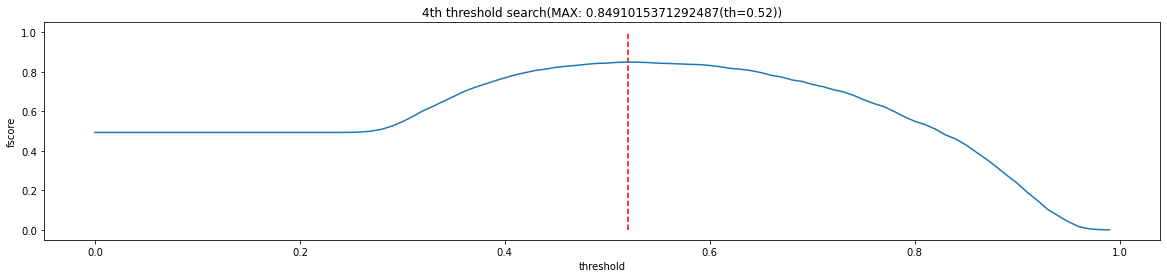

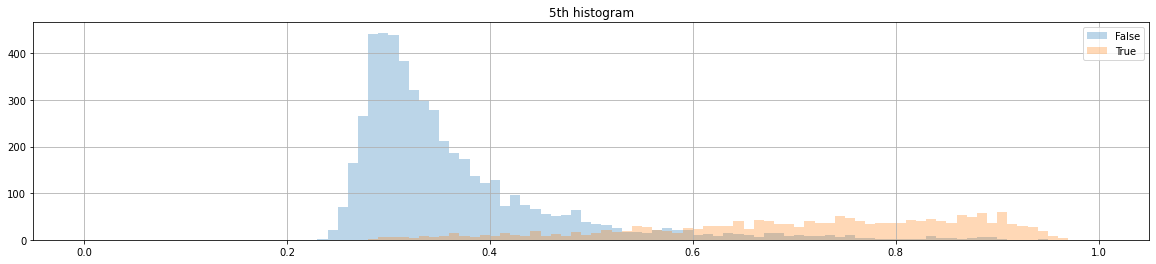

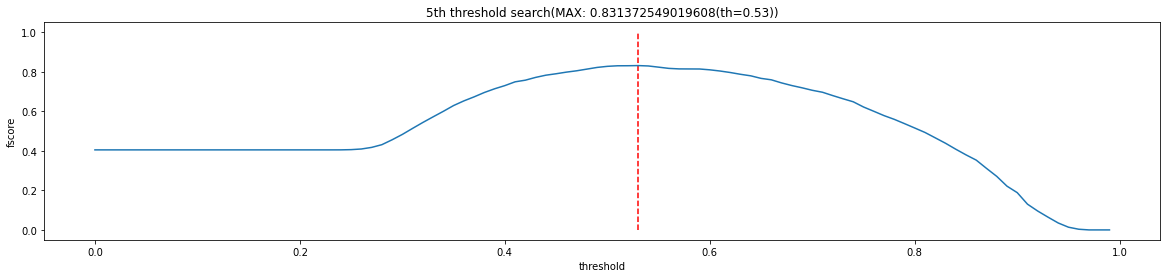

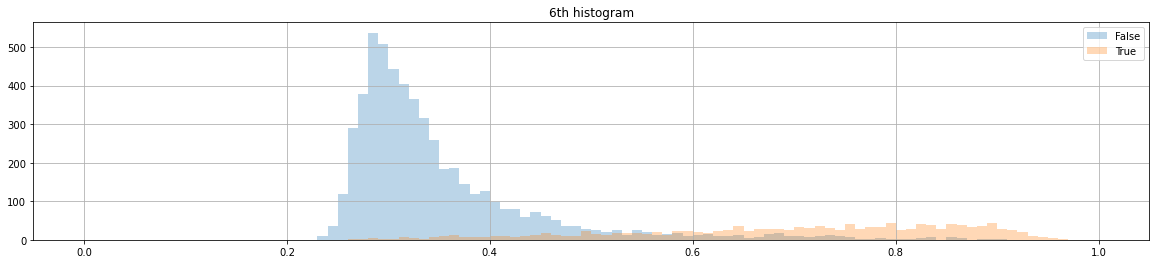

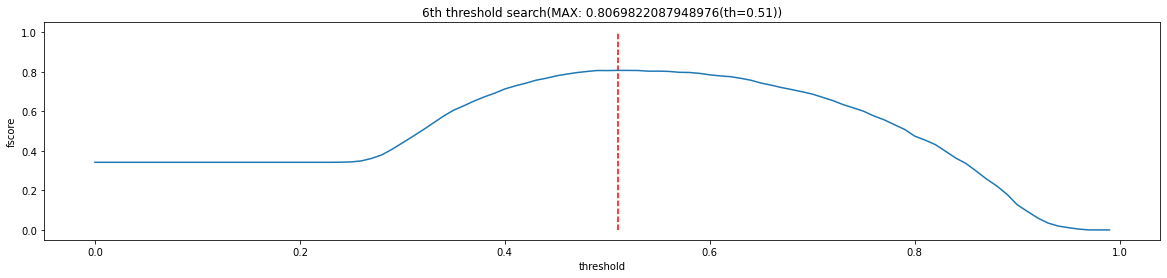

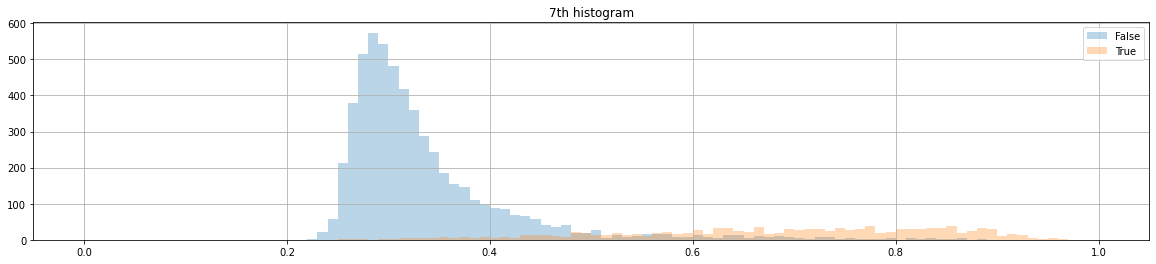

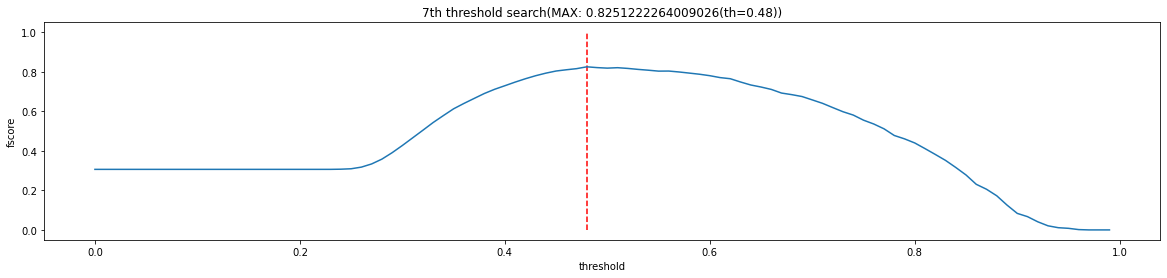

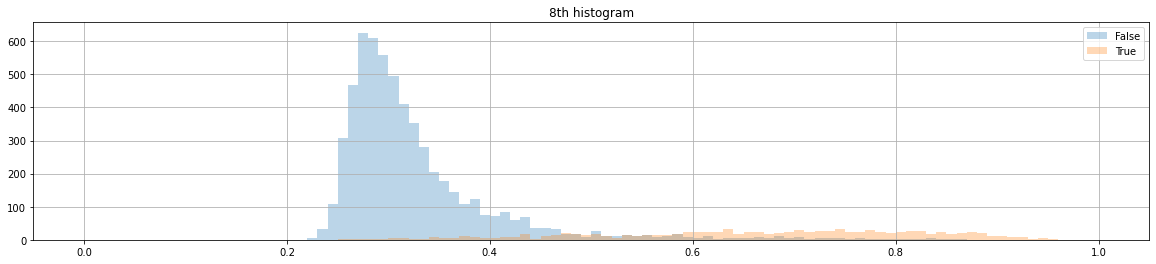

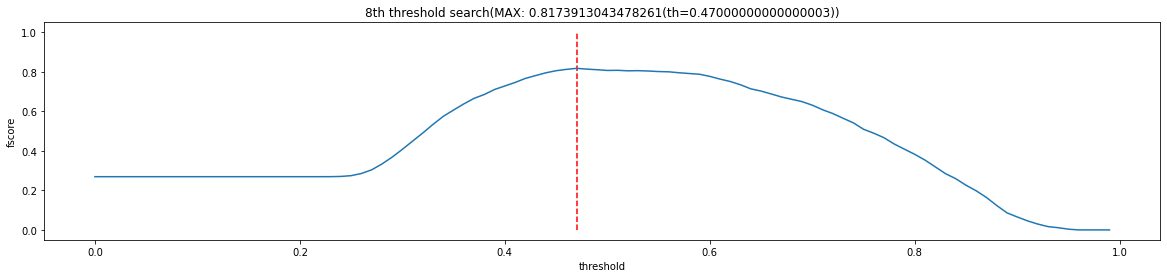

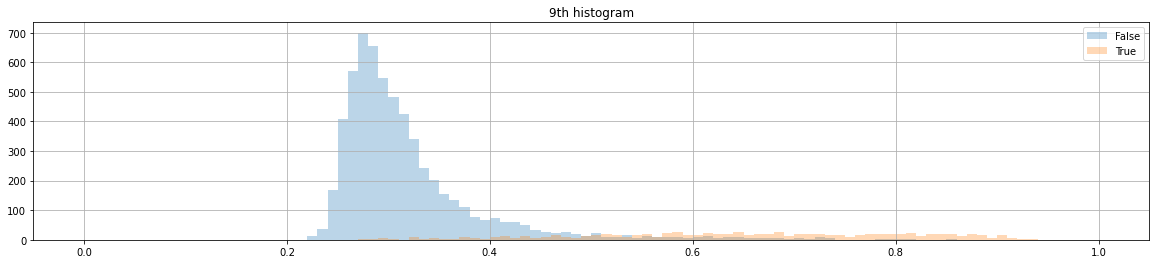

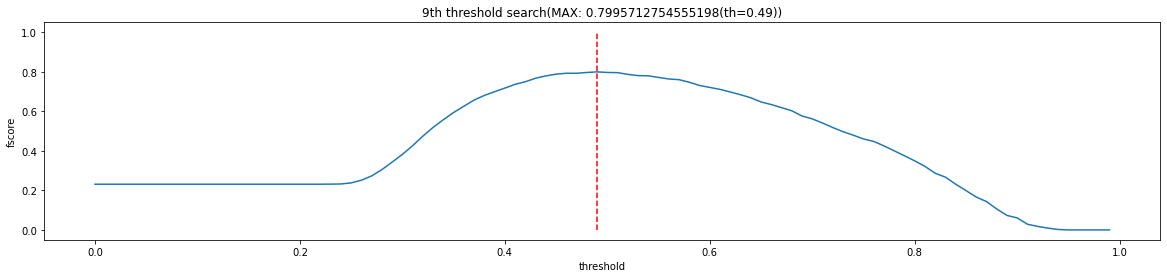

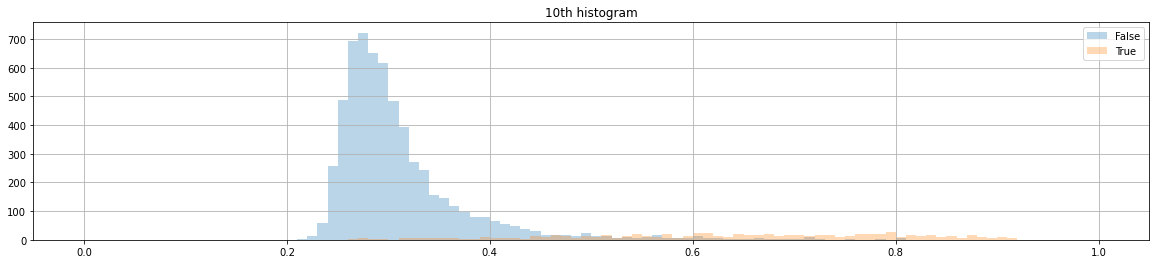

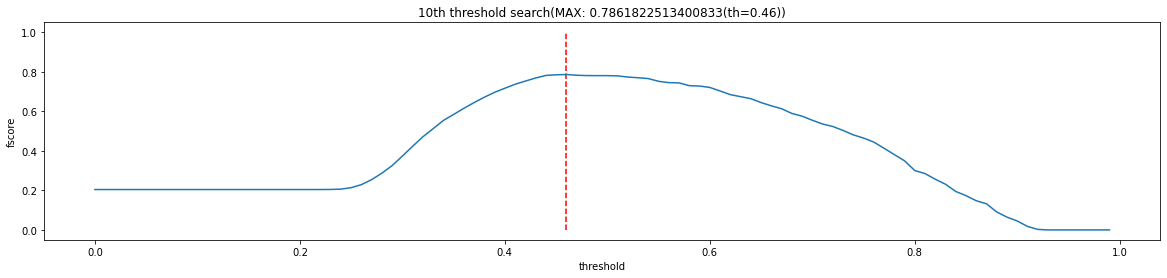

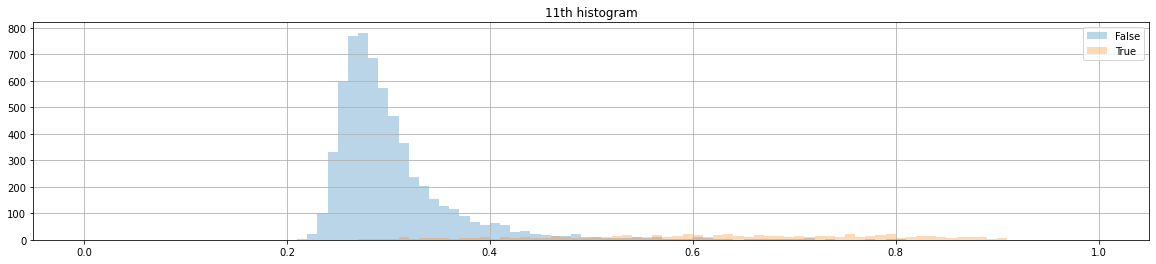

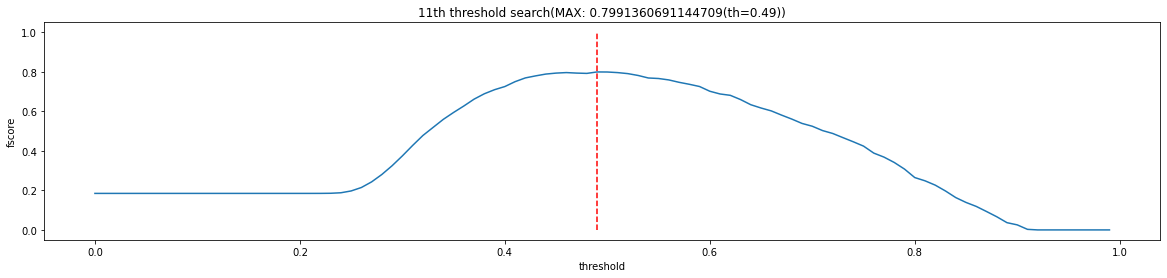

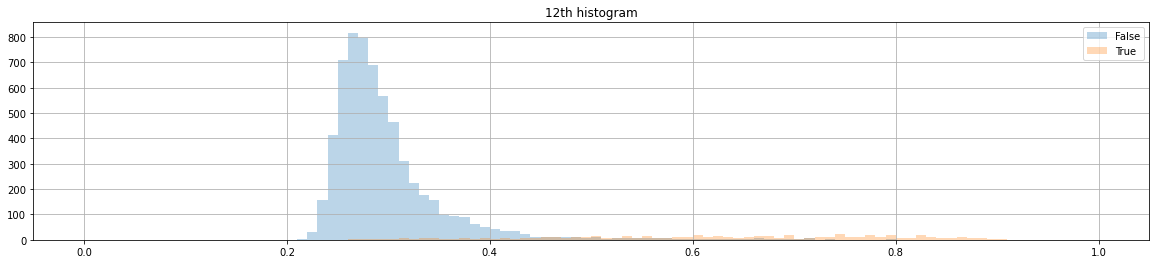

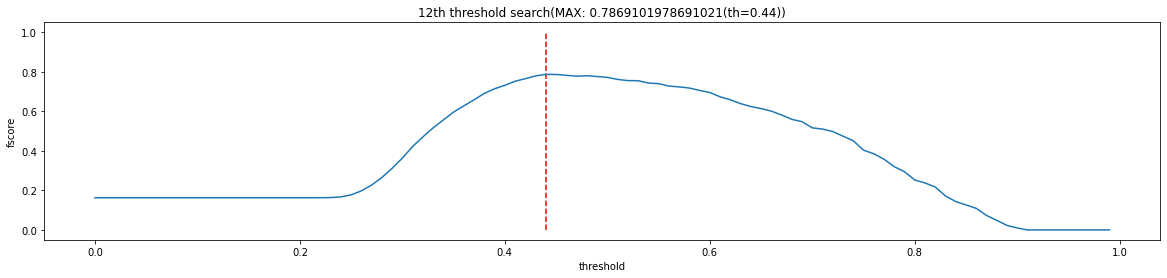

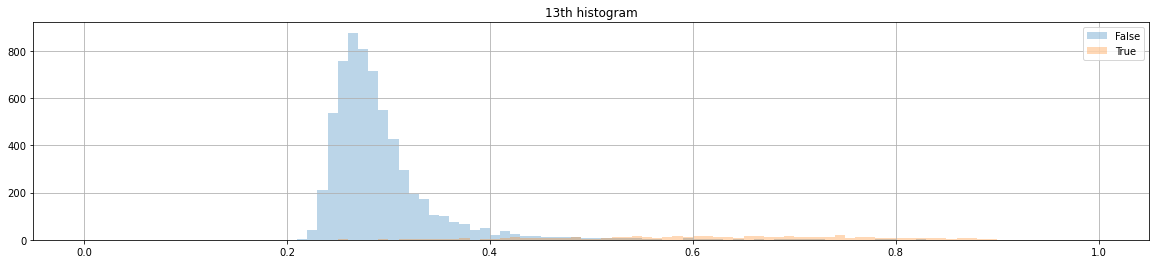

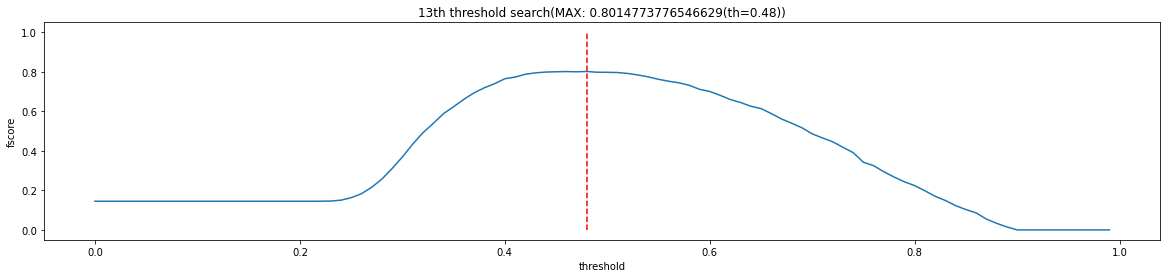

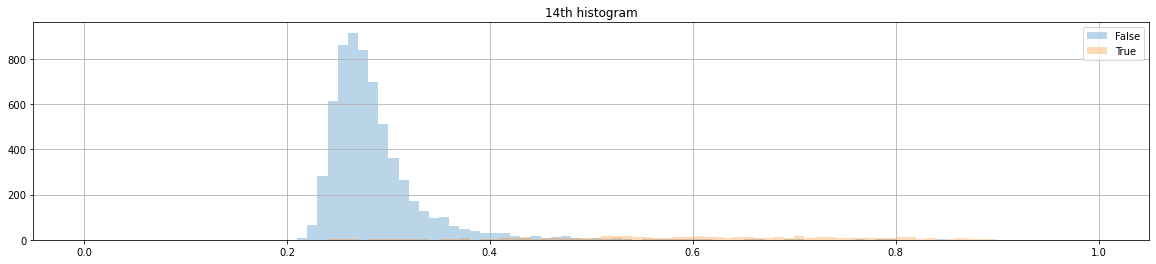

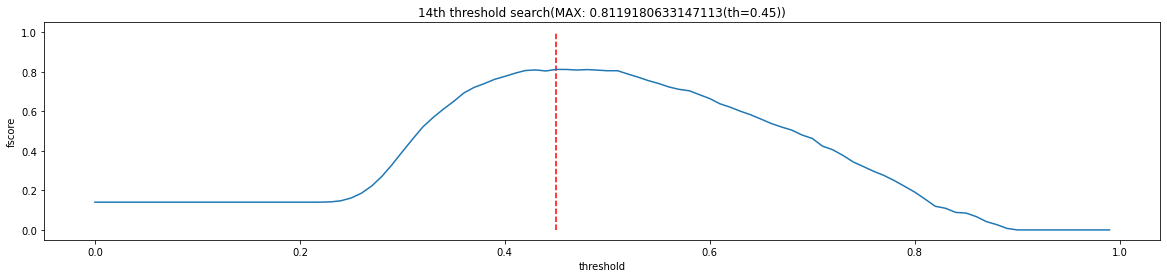

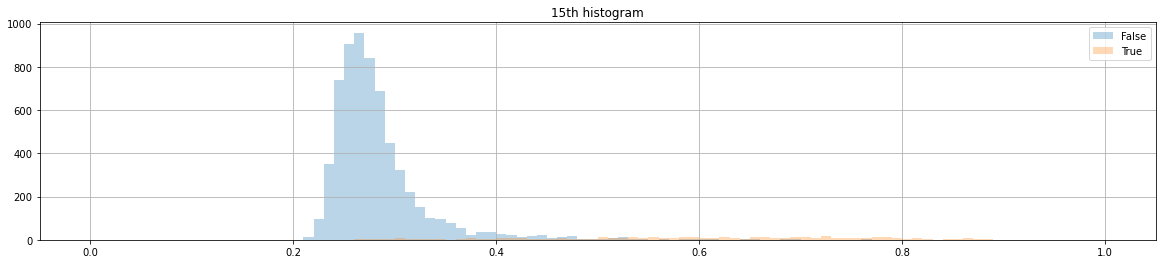

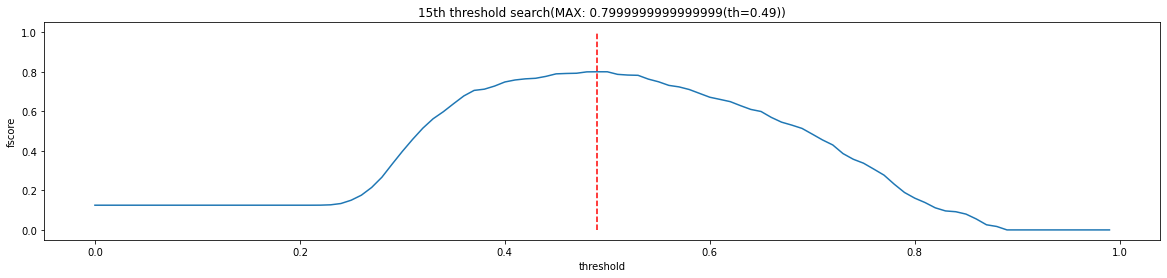

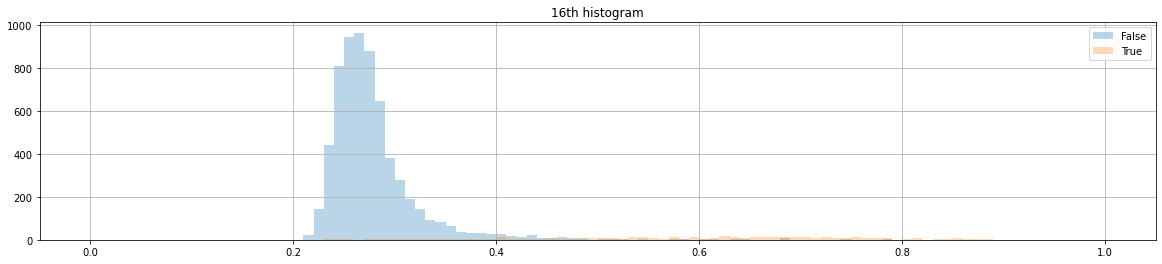

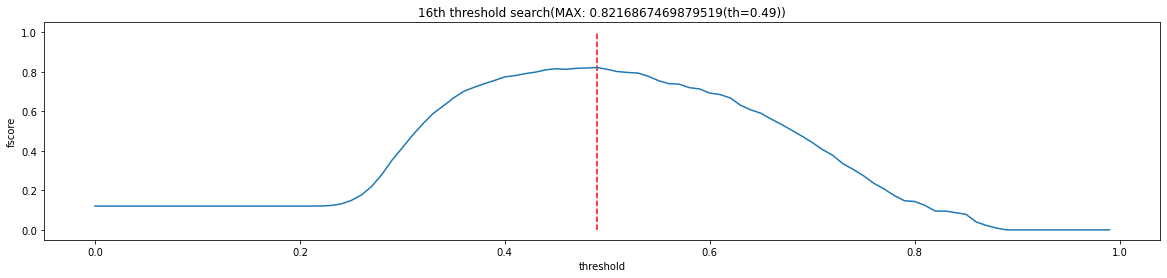

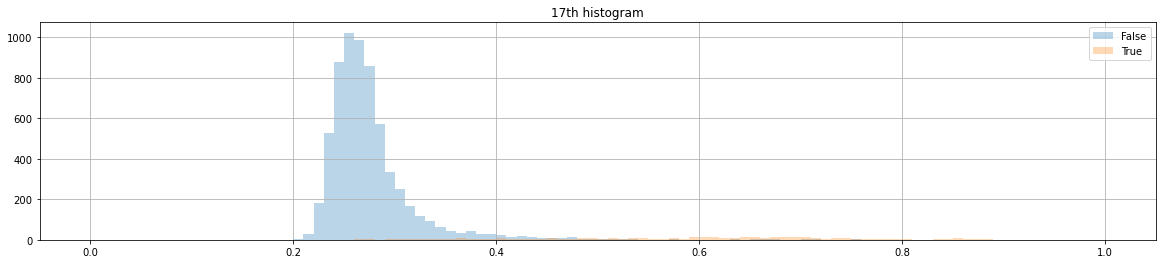

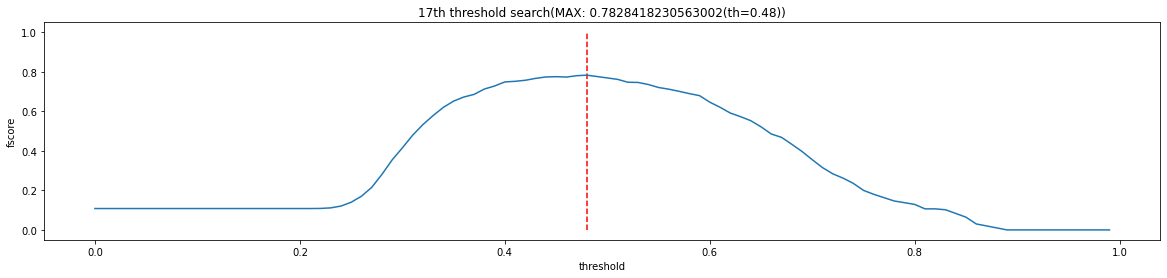

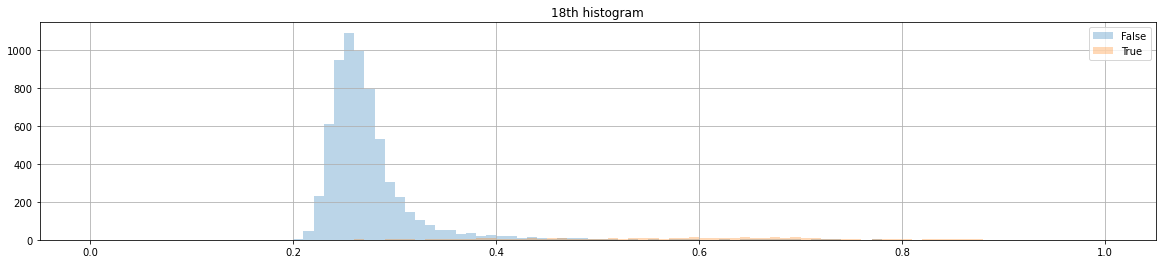

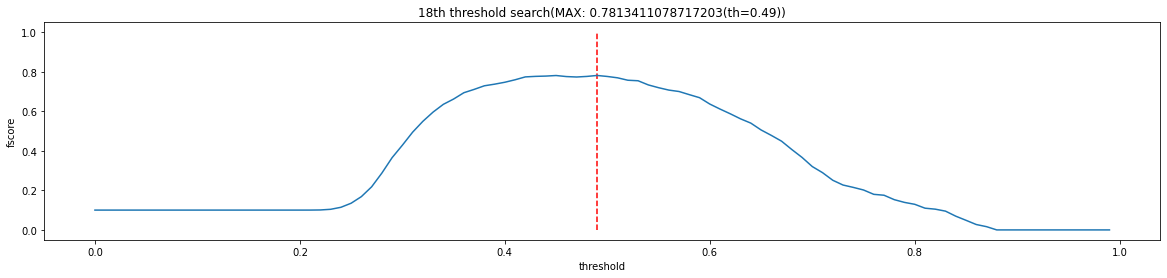

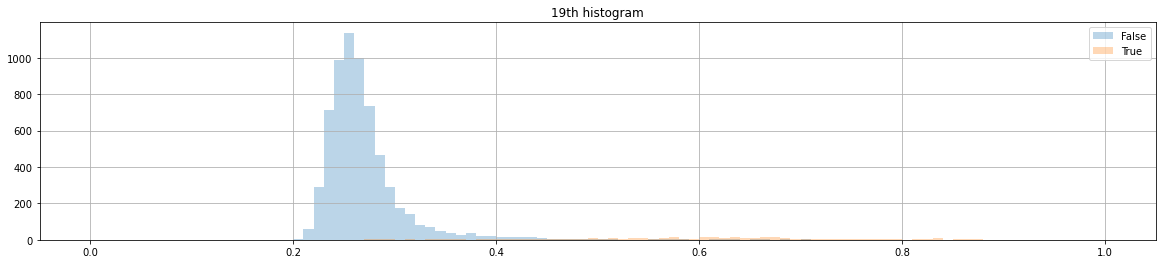

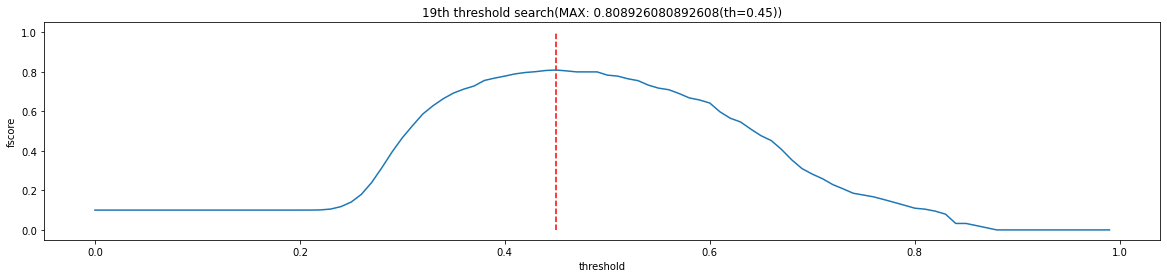

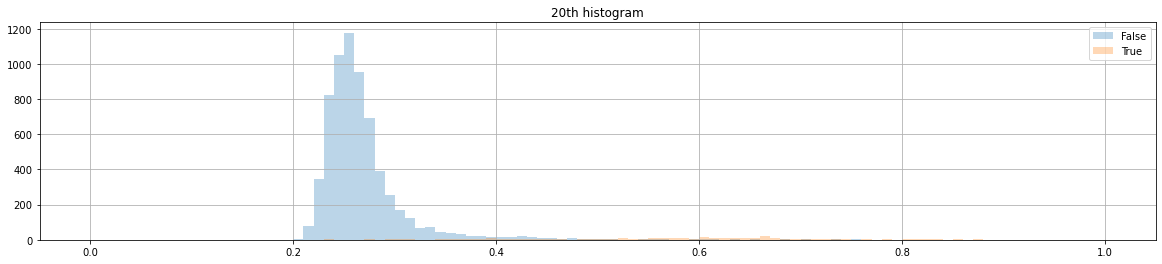

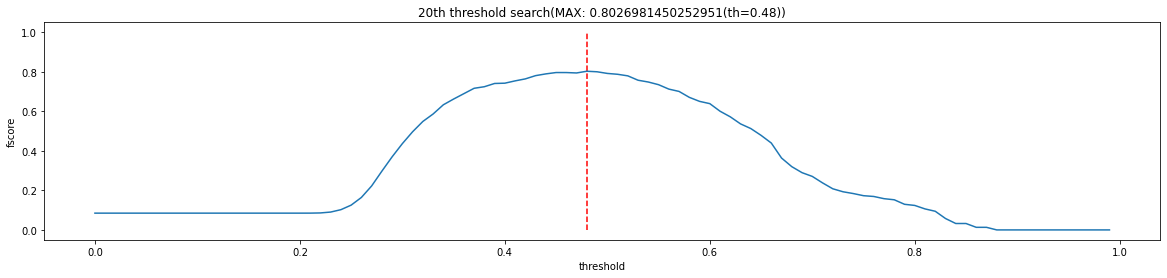

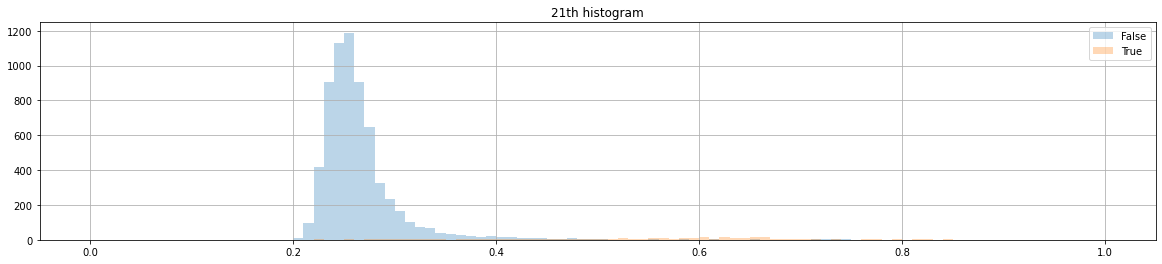

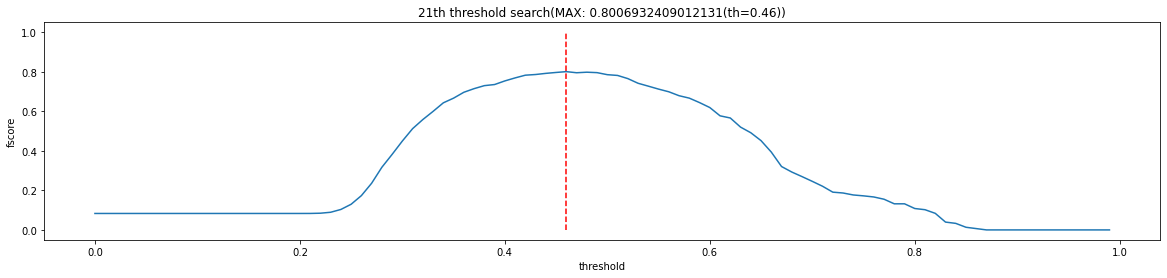

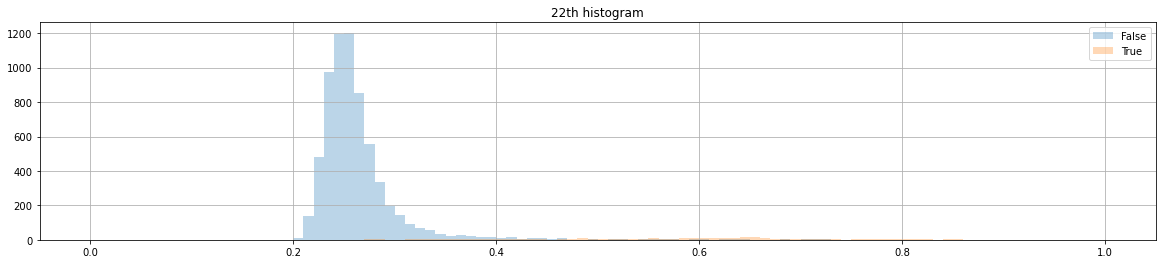

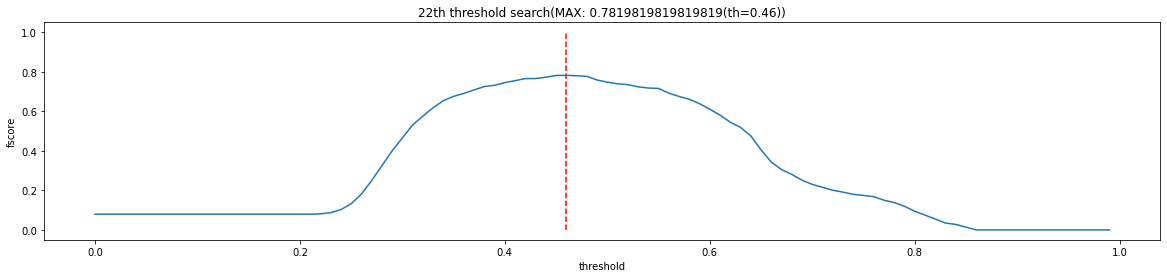

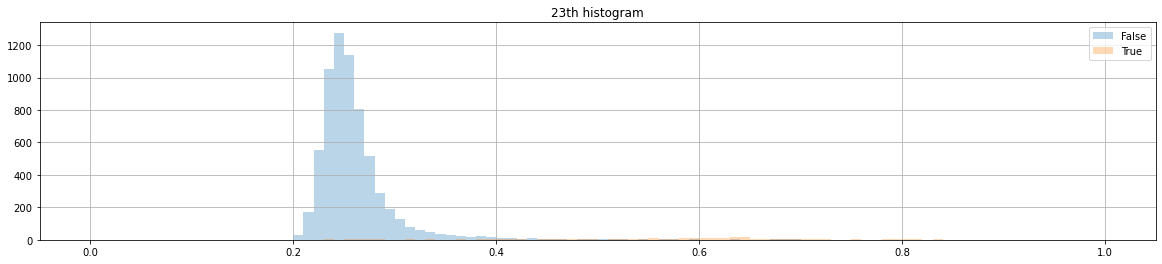

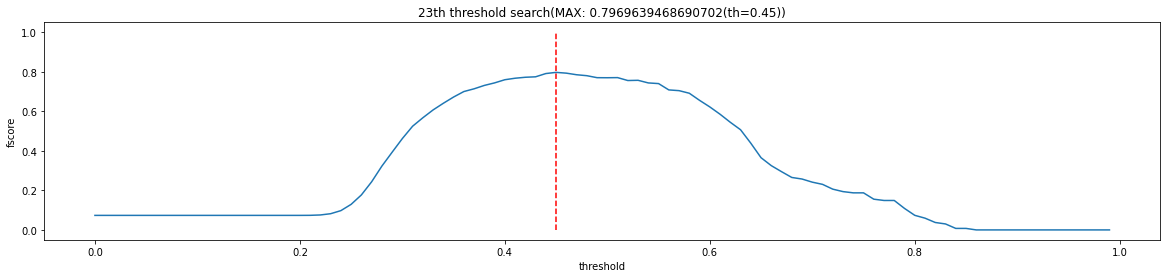

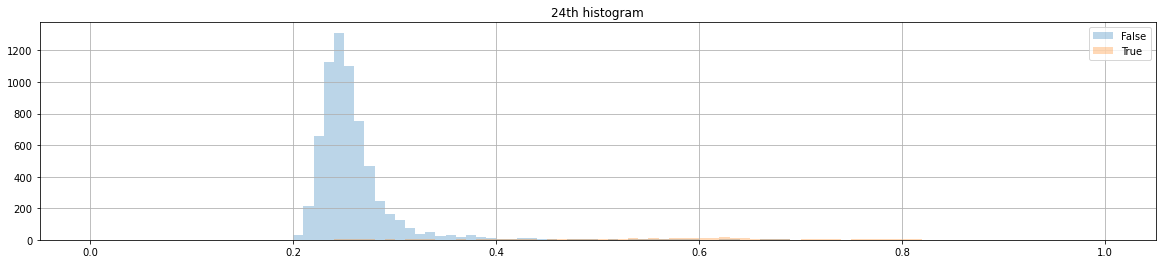

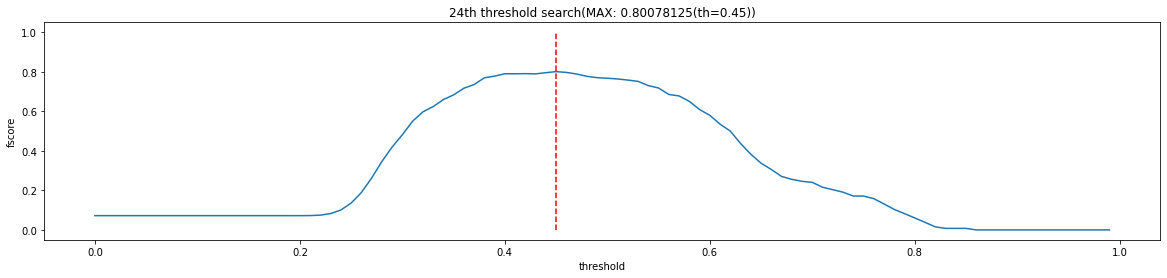

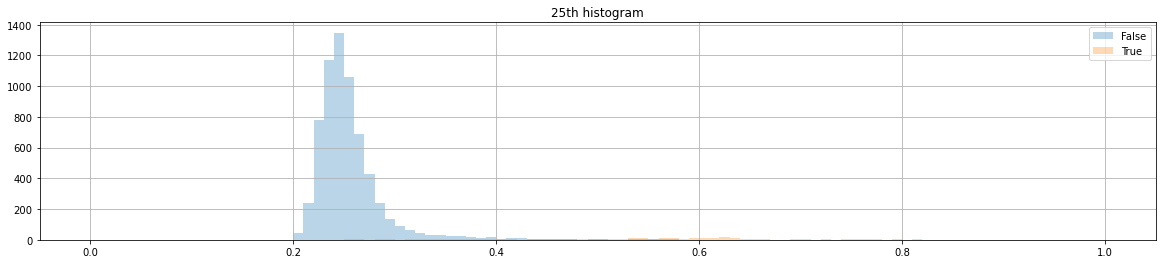

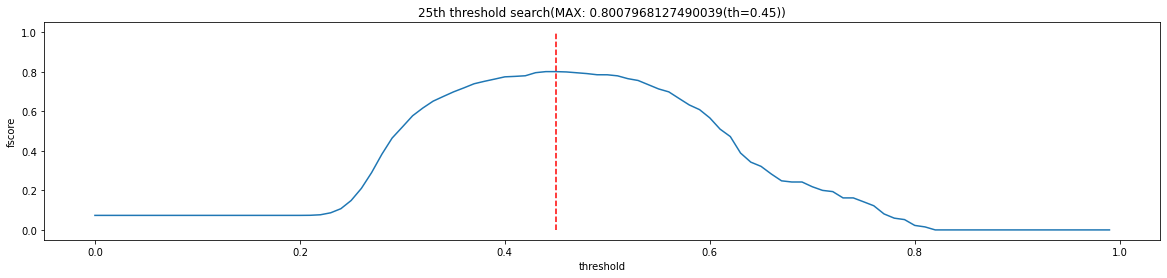

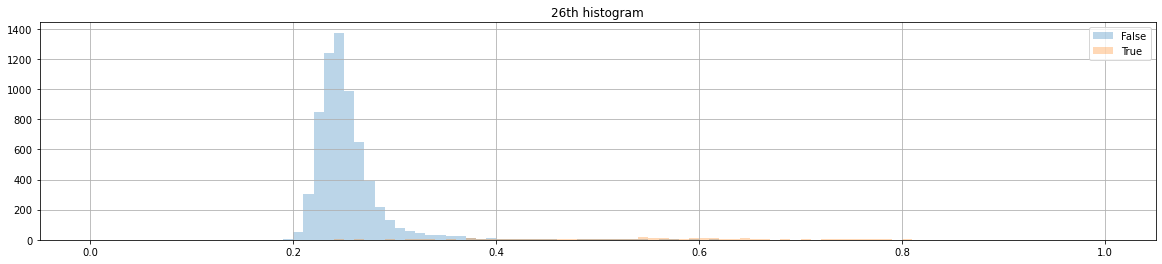

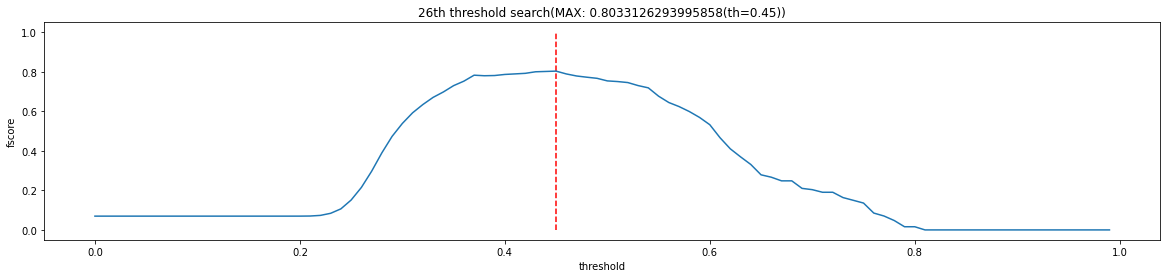

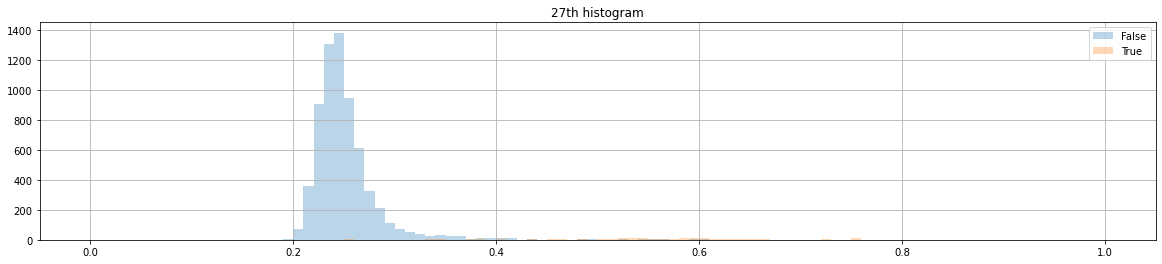

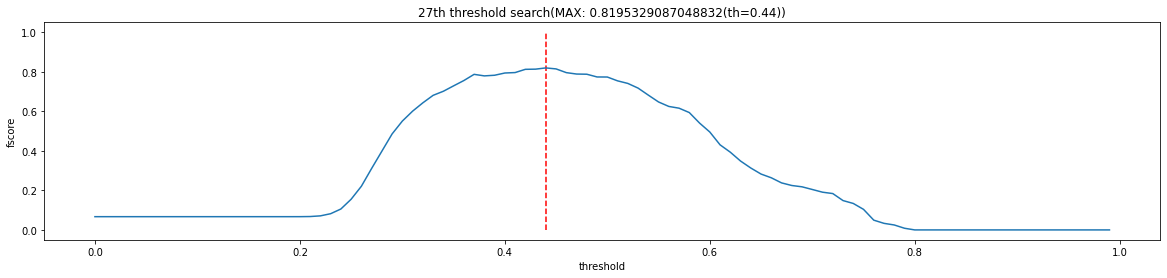

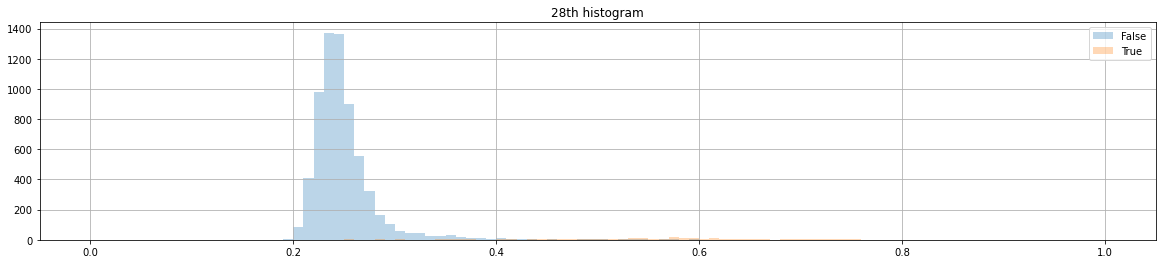

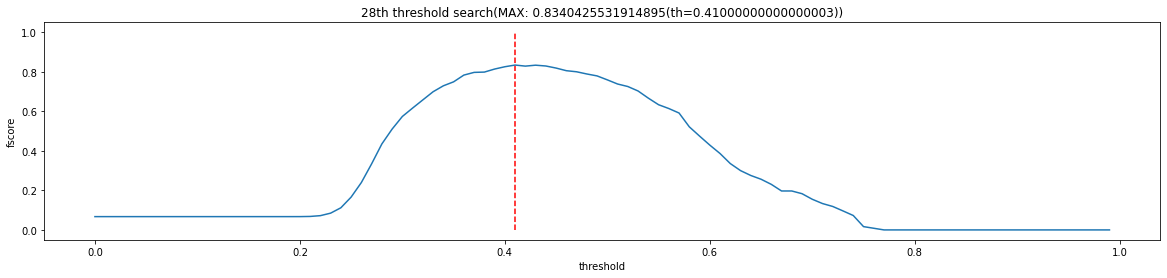

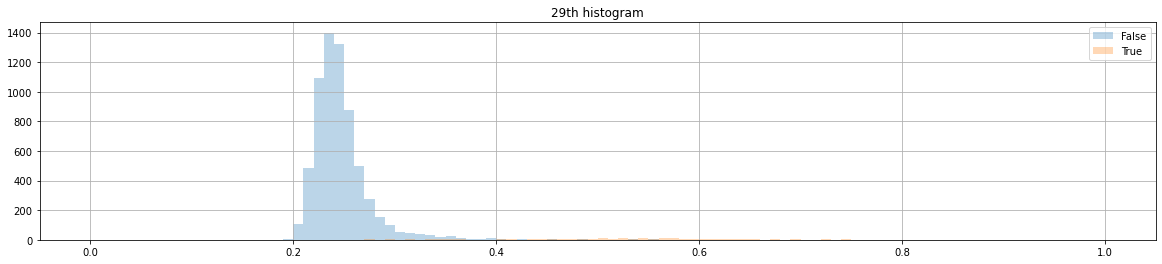

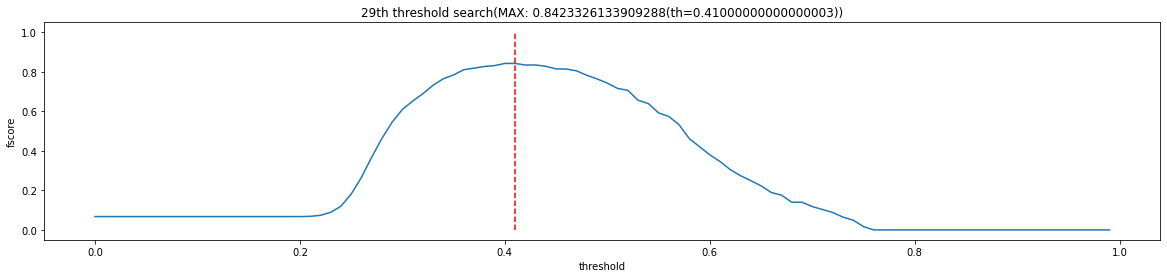

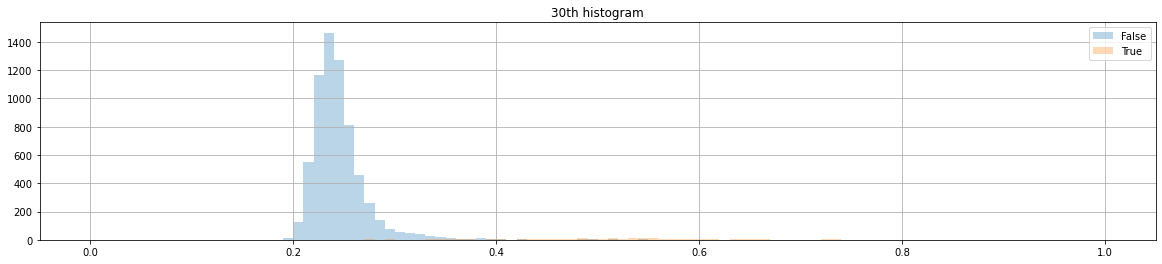

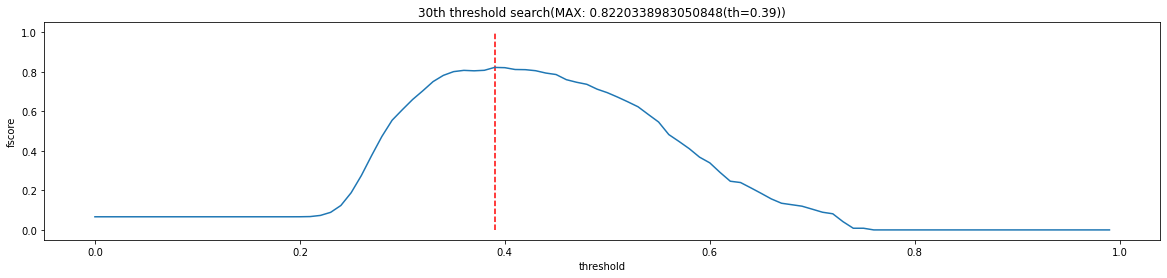

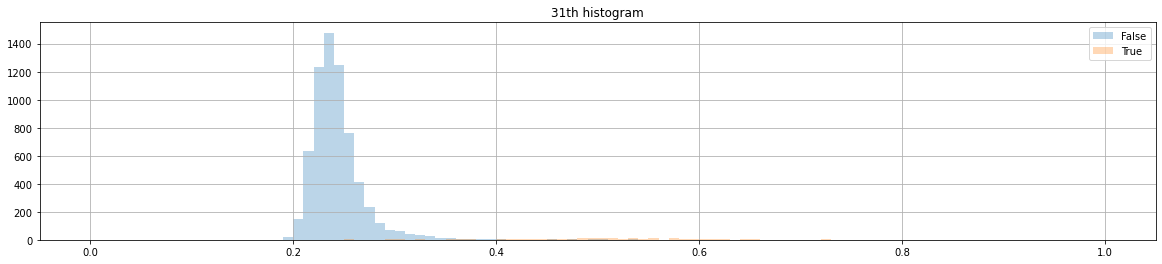

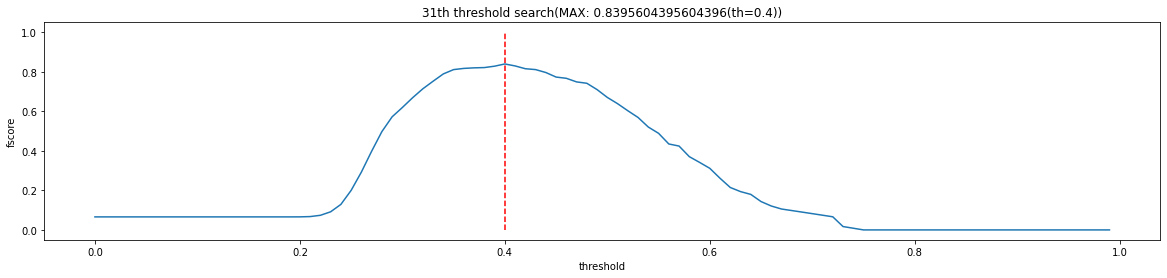

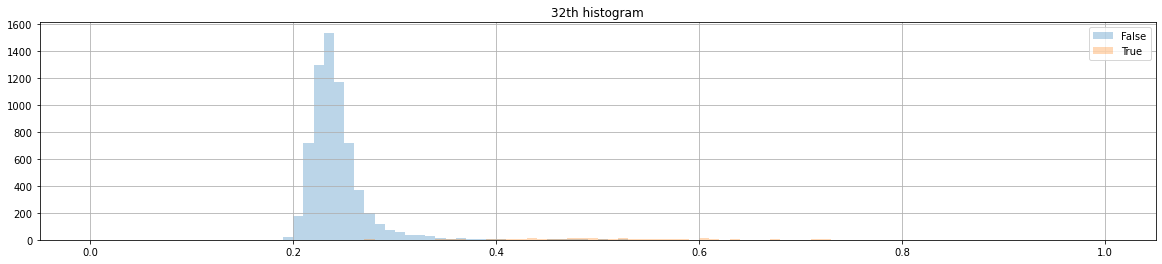

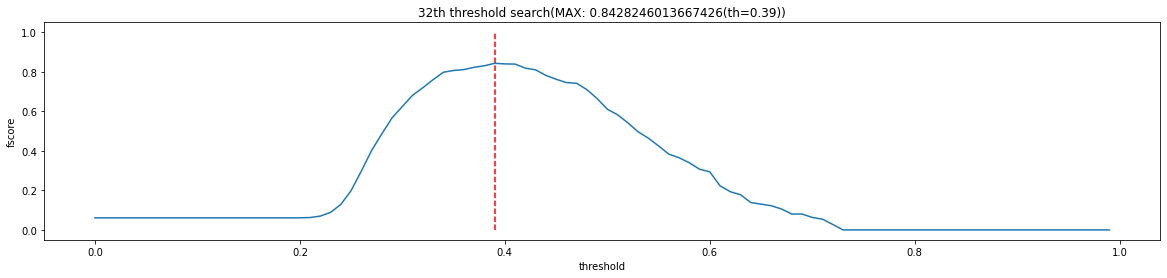

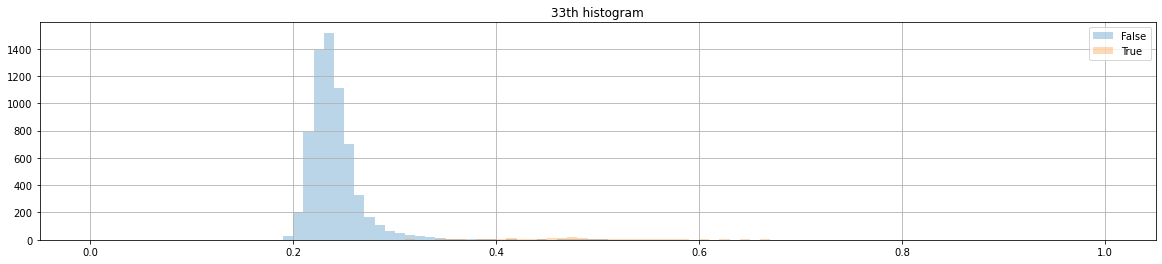

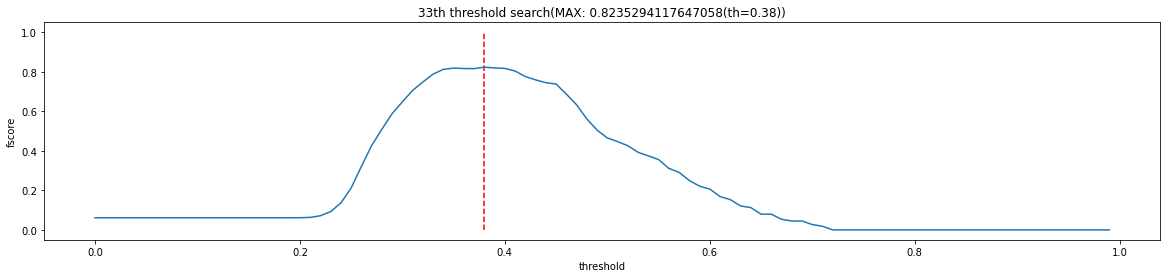

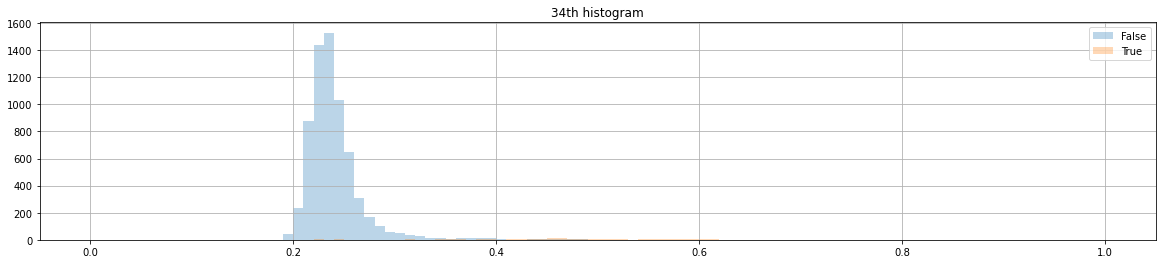

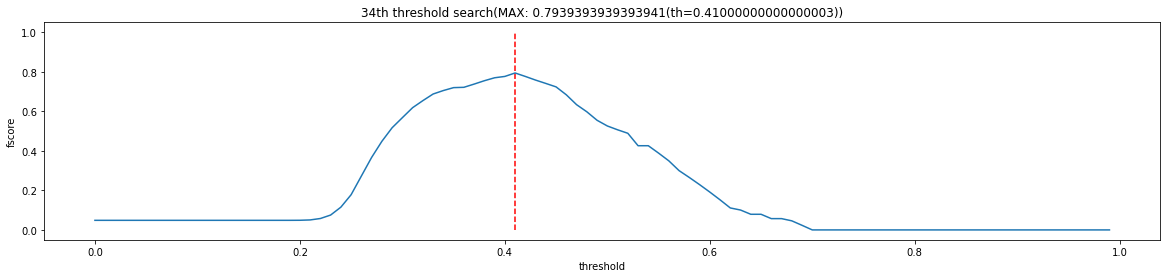

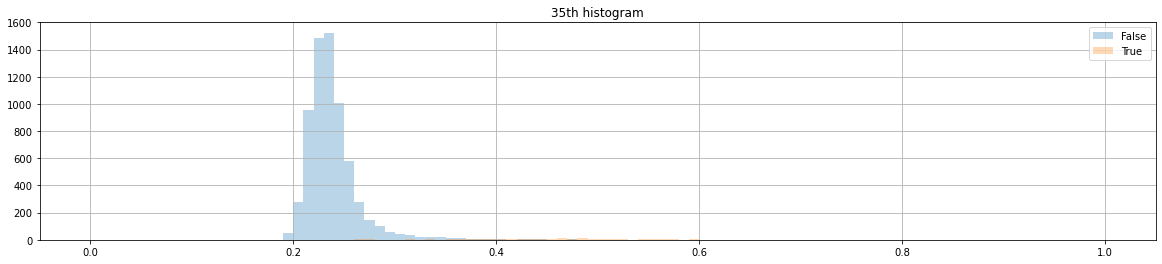

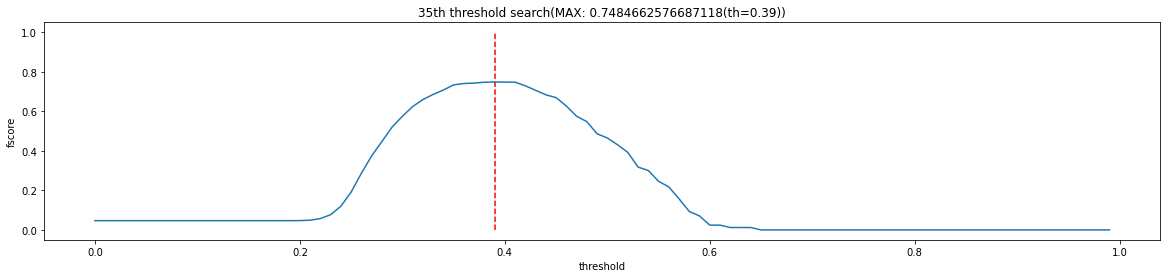

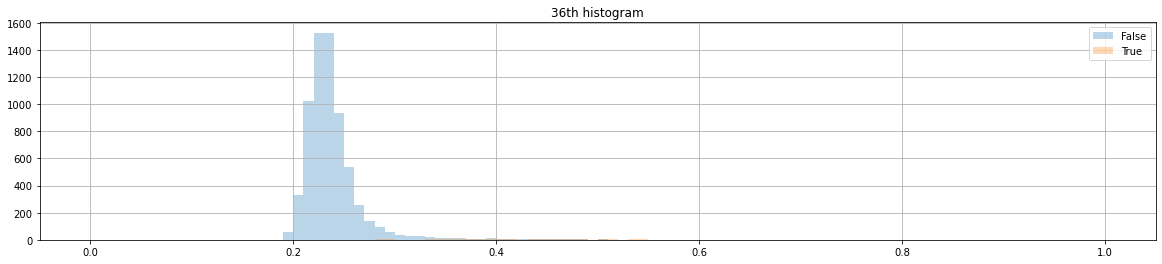

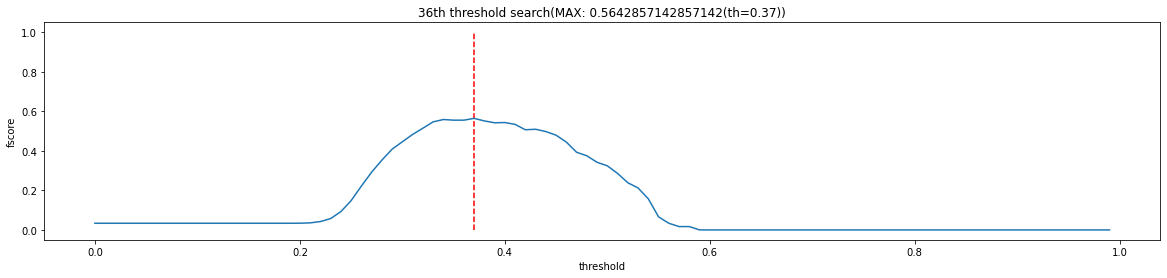

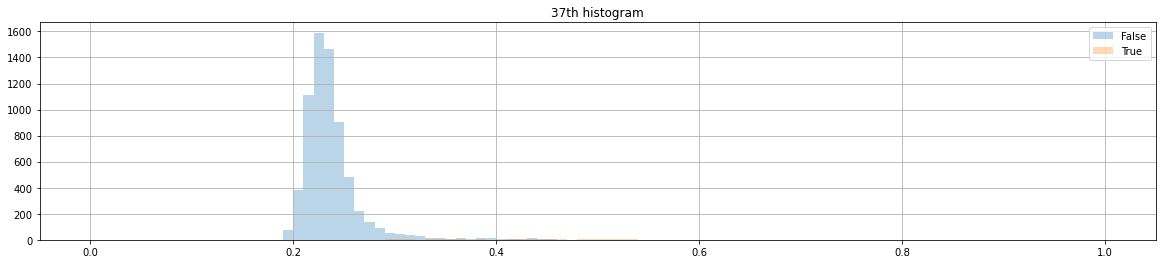

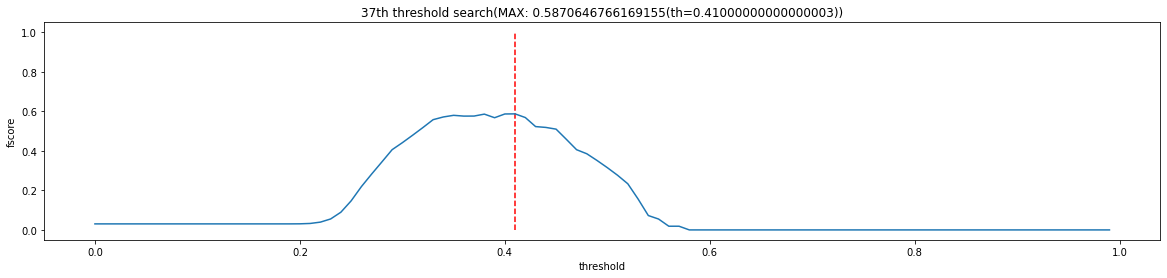

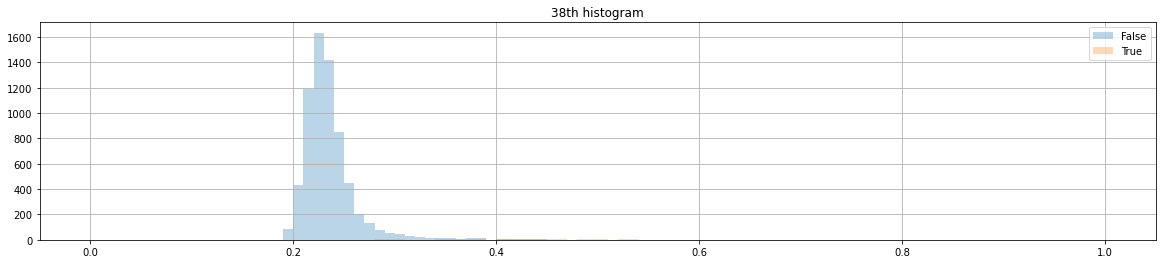

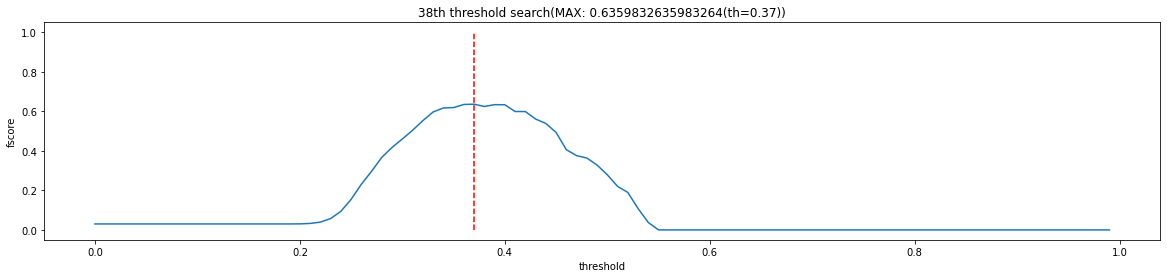

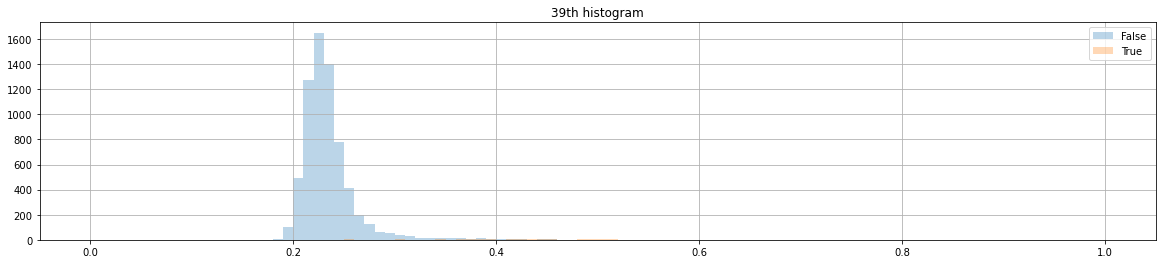

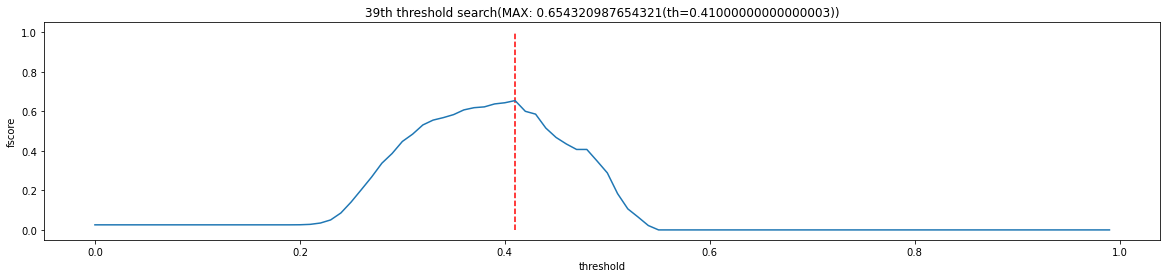

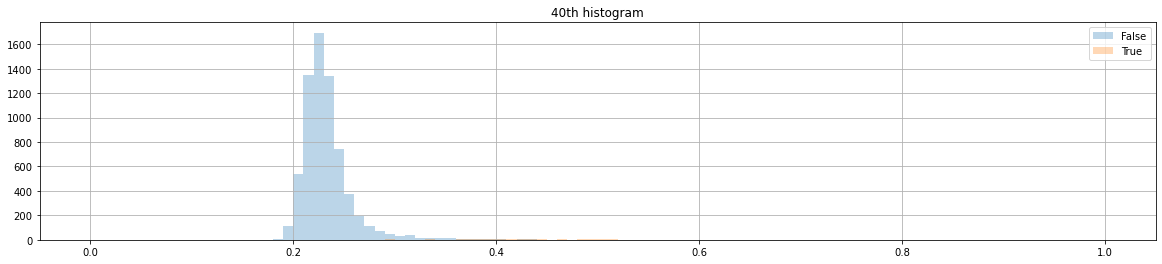

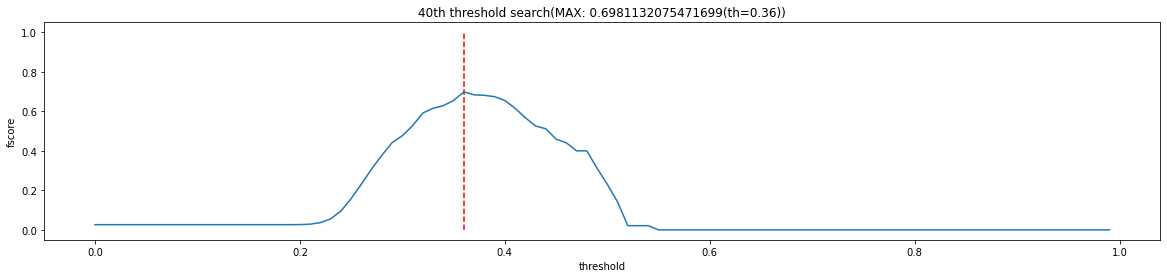

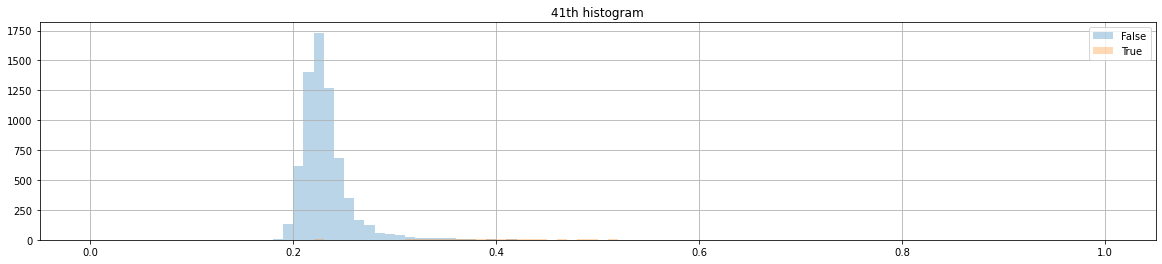

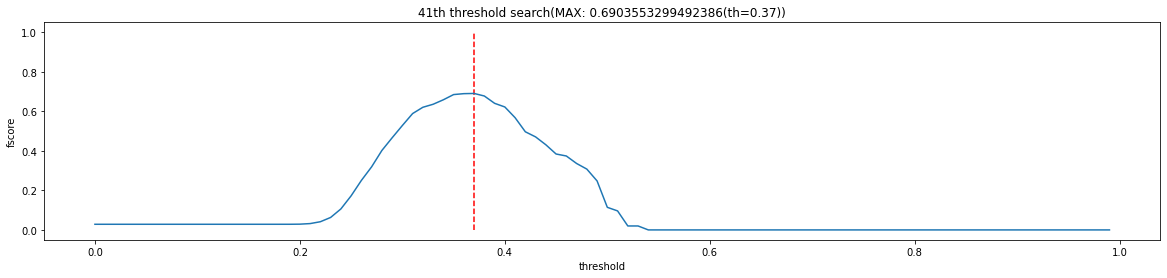

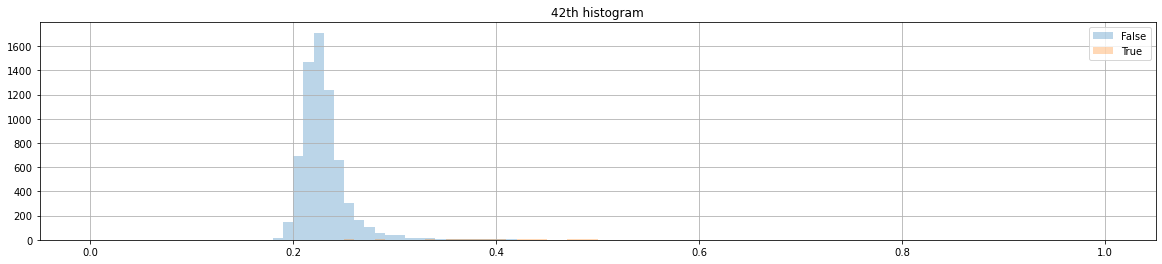

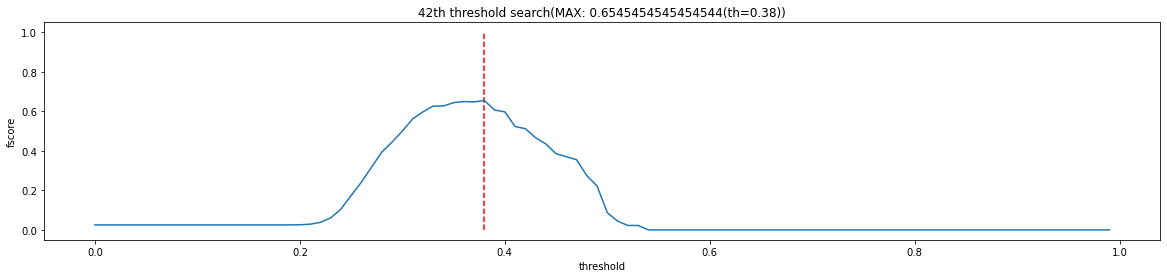

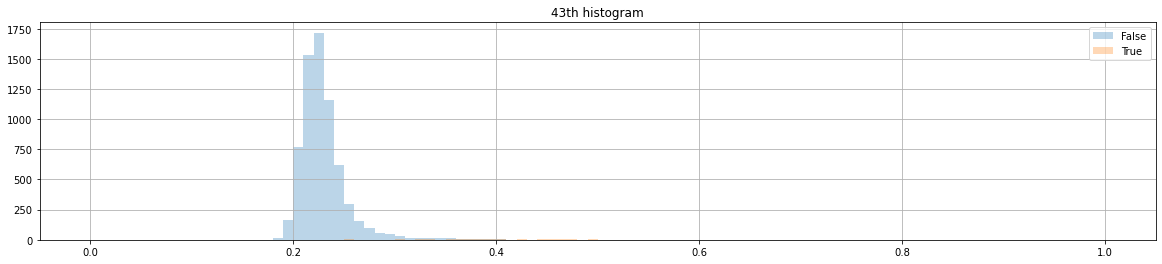

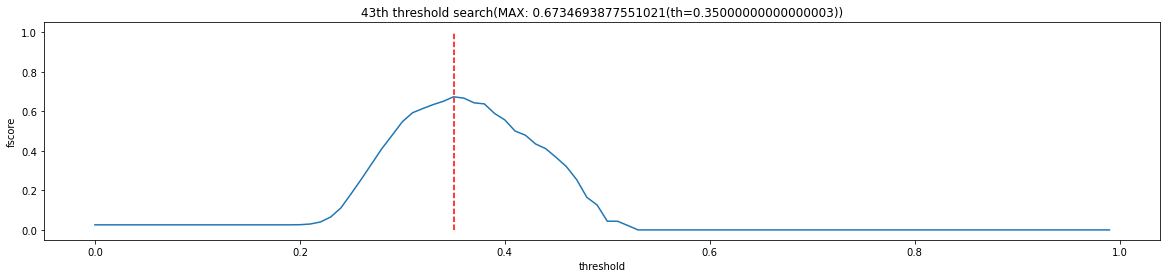

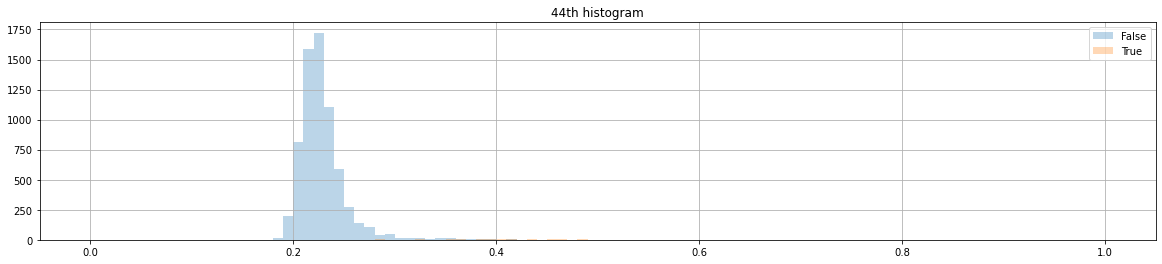

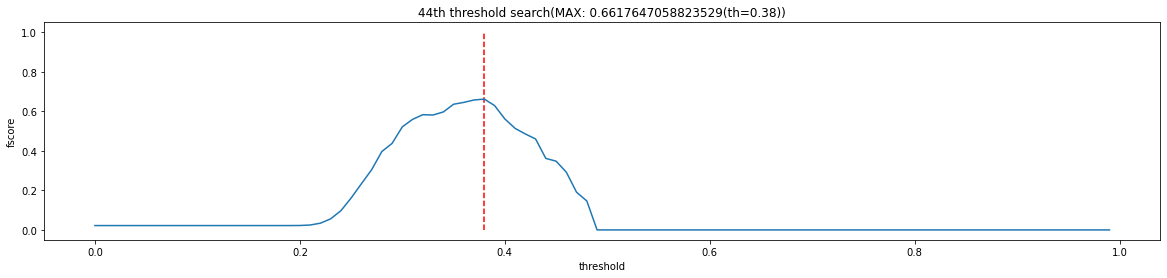

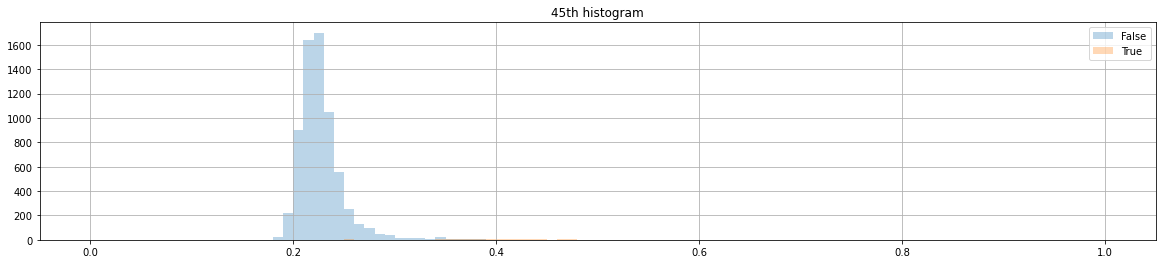

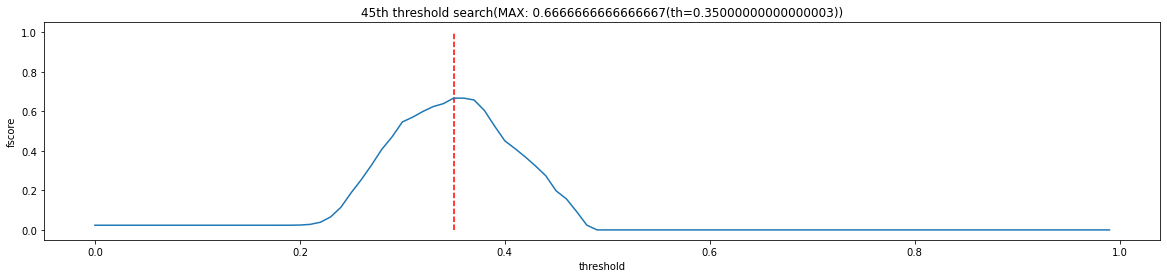

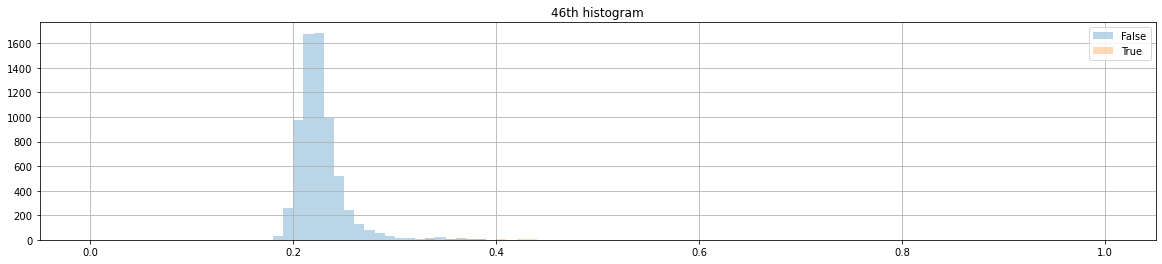

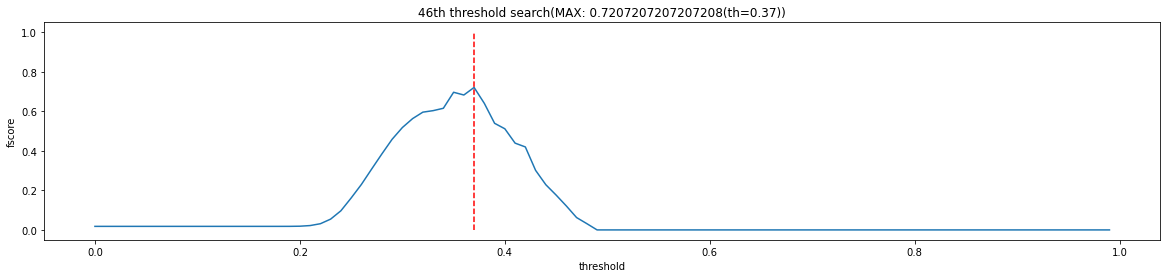

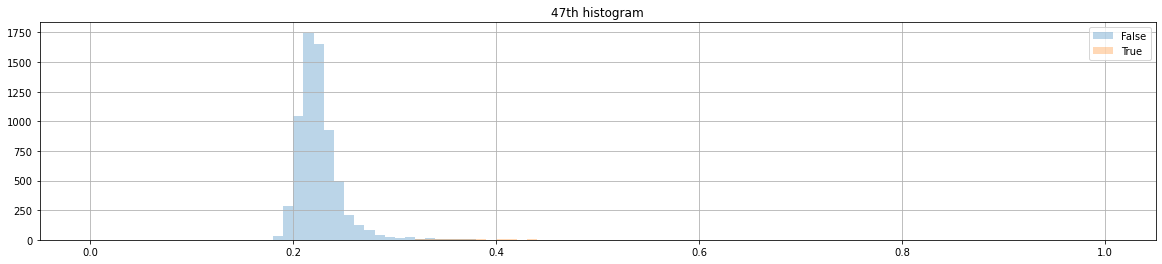

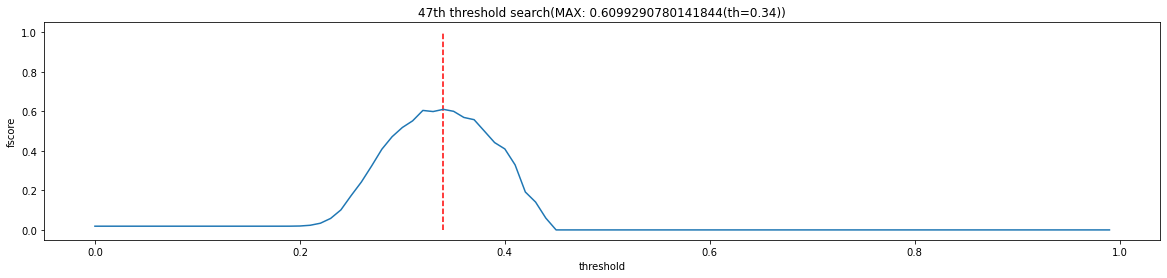

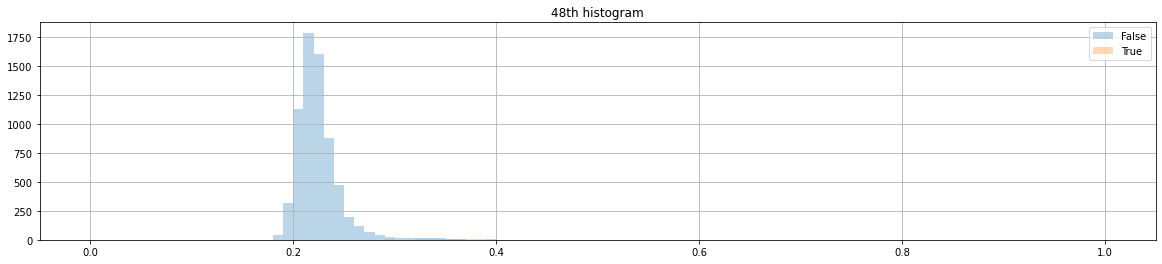

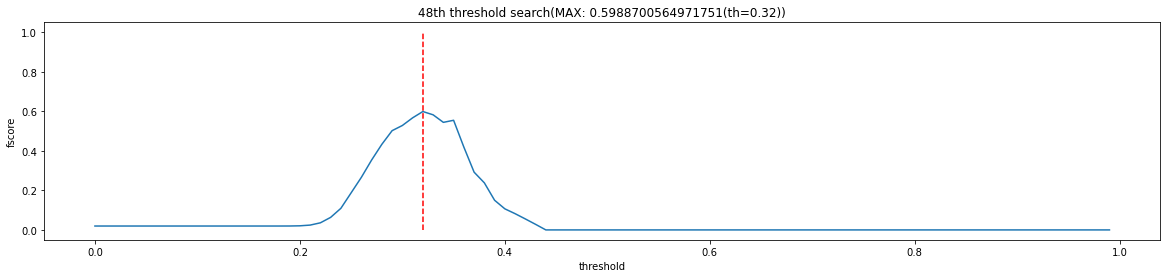

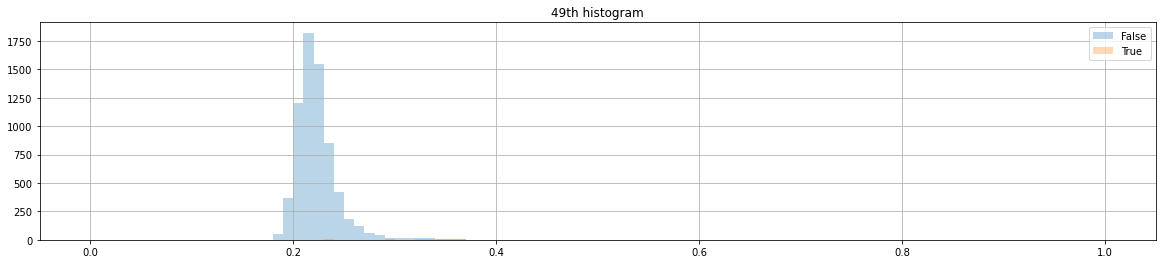

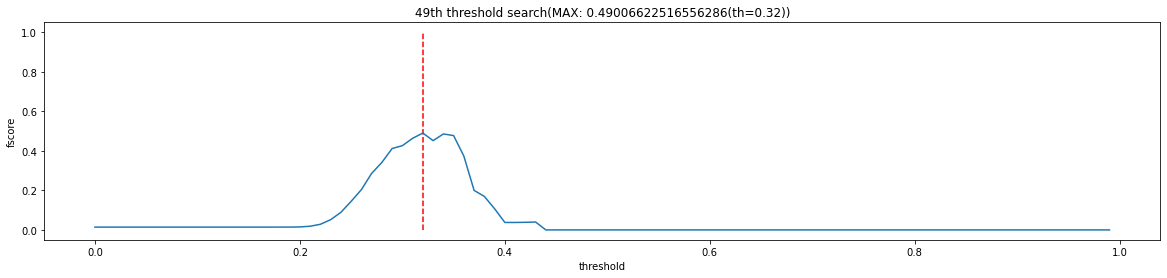

In [93]:
best_ths = []
for nth in np.arange(50):
    best_ths.append(calc_fscore(df_ret, nth))

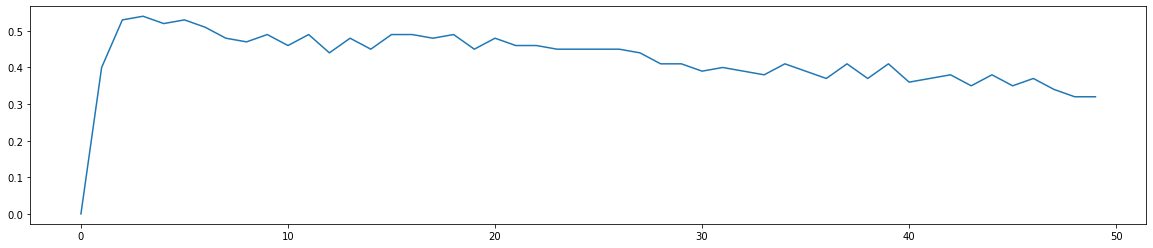

In [97]:
plt.figure(figsize=(20, 4))
plt.plot(np.arange(50), best_ths)

In [101]:
def f(x):
    return -0.0045*x + 0.53
    
[0, 0.4] + f(np.arange(48)).tolist()

[0,
 0.4,
 0.53,
 0.5255000000000001,
 0.521,
 0.5165000000000001,
 0.512,
 0.5075000000000001,
 0.503,
 0.49850000000000005,
 0.49400000000000005,
 0.48950000000000005,
 0.48500000000000004,
 0.48050000000000004,
 0.47600000000000003,
 0.47150000000000003,
 0.467,
 0.4625,
 0.458,
 0.4535,
 0.44900000000000007,
 0.4445,
 0.44000000000000006,
 0.43550000000000005,
 0.43100000000000005,
 0.42650000000000005,
 0.42200000000000004,
 0.41750000000000004,
 0.41300000000000003,
 0.40850000000000003,
 0.404,
 0.3995000000000001,
 0.395,
 0.39050000000000007,
 0.386,
 0.38150000000000006,
 0.377,
 0.37250000000000005,
 0.36800000000000005,
 0.36350000000000005,
 0.35900000000000004,
 0.35450000000000004,
 0.35000000000000003,
 0.34550000000000003,
 0.3410000000000001,
 0.3365,
 0.3320000000000001,
 0.3275,
 0.32300000000000006,
 0.3185]

In [98]:
best_ths

[0.0,
 0.4,
 0.53,
 0.54,
 0.52,
 0.53,
 0.51,
 0.48,
 0.47000000000000003,
 0.49,
 0.46,
 0.49,
 0.44,
 0.48,
 0.45,
 0.49,
 0.49,
 0.48,
 0.49,
 0.45,
 0.48,
 0.46,
 0.46,
 0.45,
 0.45,
 0.45,
 0.45,
 0.44,
 0.41000000000000003,
 0.41000000000000003,
 0.39,
 0.4,
 0.39,
 0.38,
 0.41000000000000003,
 0.39,
 0.37,
 0.41000000000000003,
 0.37,
 0.41000000000000003,
 0.36,
 0.37,
 0.38,
 0.35000000000000003,
 0.38,
 0.35000000000000003,
 0.37,
 0.34,
 0.32,
 0.32]

In [99]:
np.array([1, 2, 3]) > np.array([1.5, 1.5, 1.5])

array([False,  True,  True])